# first GMM APPROACH

In [125]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.patches import Ellipse
import math
import edward as ed
import tensorflow as tf
from matplotlib import pyplot as plt

# import data
* all_sky_star = []: skies
    * all_sky_star[i]: one sky
        * all_sky_star[i][0]: galaxy name
        * all_sky_star[i][1]: galaxy x position
        * all_sky_star[i][2]: galaxy y position
        * all_sky_star[i][3]: galaxy E1
        * all_sky_star[i][4]: galaxy E2
* halo = []:halos
    * halo[i] :halo for sky i
        * halo[i][0]: sky name
        * halo[i][1]: number of halos
        * halo[i][2]: halo1 x
        * halo[i][3]: halo1 y
        * ...
        * halo[i][7]: halo3 y

In [283]:
#path = "~/probp.finalproject/datasets"
path = "~/Developer/probp.finalproject.darkMatter/datasets"
all_sky_star = []
for sky in np.arange(1,301,1):
    sky_path = "Train_Skies/Training_Sky"+str(sky)+".csv"
    halo_path = "Training_halos.csv"
    star = (pd.read_csv(path+"/"+sky_path).values)
    all_sky_star.append(star)
halo = (pd.read_csv(path+"/"+halo_path).values)


In [293]:
#plot e1e2
sky=8
plt.clf()
#plt.scatter(all_sky_star[sky][:,3],all_sky_star[sky][:,4])
#print(halo[sky,2],halo[sky,3])
halos = halo[sky,2:4]
plt.show()

e1,e2 = np.array(all_sky_star[sky][:,3:4],dtype=np.float32),np.array(all_sky_star[sky][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
var_e1 = np.var(all_sky_star[sky][:,3])
var_e2 = np.var(all_sky_star[sky][:,4])
#print(b1)
print(var_e2)
select = a1/b1>2
select = select.reshape(select.shape[0])
pos_xy = all_sky_star[sky][:,1:3]
num = pos_xy.shape[0]
e1_e2 = all_sky_star[sky][:,3:5]
print(num)
###

e1,e2 = np.array(all_sky_star[0][:,3:4],dtype=np.float32),np.array(all_sky_star[0][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
select = a1/b1>2
select = select.reshape(select.shape[0])

pos_all_xy = all_sky_star[0][select,1:3]
pos_all_halo = np.ones(all_sky_star[0][select,1:3].shape)*halo[0,2:4]
pos_all_e1_e2 = all_sky_star[0][select,3:5]

for sky2 in np.arange(1,300,1):
    e1,e2 = np.array(all_sky_star[sky2][:,3:4],dtype=np.float32),np.array(all_sky_star[sky2][:,4:5],dtype=np.float32)
    sq = np.sqrt(e1**2+e2**2)
    q = ((1.+sq)/(1-sq))**2
    a1 = np.sqrt(q/(1+q))
    b1 = np.sqrt(1./(1+q))
    select = a1/b1>2
    select = select.reshape(select.shape[0])
    pos_all_xy = np.concatenate((pos_all_xy,all_sky_star[sky2][select,1:3]),axis = 0)
    pos_all_e1_e2 = np.concatenate((pos_all_e1_e2,all_sky_star[sky2][select,3:5]),axis = 0)
    pos_all_halo = np.concatenate((pos_all_halo,np.ones(all_sky_star[sky2][select,1:3].shape)*halo[sky2,2:4]),axis = 0)
print(pos_all_xy.shape)
print(pos_all_halo.shape)
print(pos_all_e1_e2.shape)

0.04162243425321779
574


IndexError: boolean index did not match indexed array along dimension 0; dimension is 348 but corresponding boolean dimension is 574

# dist checks

(530,)
(530,)


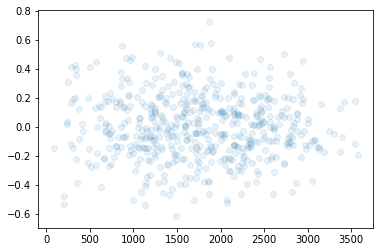

In [35]:
# long/short vs distance
e1,e2 = np.array(all_sky_star[sky][:,3:4],dtype=np.float32),np.array(all_sky_star[sky][:,4:5],dtype=np.float32)
sq = np.sqrt(e1**2+e2**2)
q = ((1.+sq)/(1-sq))**2
a1 = np.sqrt(q/(1+q))
b1 = np.sqrt(1./(1+q))
#print(a1/b1)
gal_x = np.array(all_sky_star[sky][:,1],dtype=np.float32)
gal_y = np.array(all_sky_star[sky][:,2],dtype=np.float32)

l2dist = np.sqrt((gal_x-halo[sky,2])**2+(gal_y-halo[sky,3])**2)
# angle vs angle
#print(l2dist)
plt.scatter(l2dist,e2,alpha=0.1)
print(l2dist.shape)
a_b = (a1/b1).reshape(a1.shape[0])
fun = l2dist*a_b
print(fun.shape)
#plt.hist(fun,100)
plt.show()
#times angle

In [259]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, InverseGamma, Empirical

def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

N = num

# Model

X = tf.placeholder(tf.float32, [N, 2])


# Xh = Uniform(low=[0.,0.],high=[4200., 4200.])
Xh = Normal(loc=tf.constant([2100., 2100.]), scale=tf.constant(20.0))
# Xh = [2315.61, 1082.86]
#m = Uniform(low=10.,high=1000.)
m = 500
sigma = tf.constant(.05) #InverseGamma(20.0, 1.0)

l2diff = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))

sess = ed.get_session()

mu = m / tf.maximum(l2diff, 240.)**(1)

print(sess.run(sigma))
e1 = Normal(loc = tf.multiply(tangential(X, Xh, 0),mu), scale = sigma)
e2 = Normal(loc = tf.multiply(tangential(X, Xh, 1),mu), scale = sigma)


0.05


# Model Checks

In [256]:
lz = []
for i in range(N):
    if z[i] < 500:
        print(i,z[i],pos_xy[i])
        lz.append(i)
        
#for t in lz:
#    print('obs:', X_e1[t] / X_e2[t] , sess.run(l2diff, {X:pos_xy})[t])
#    x0 = tangential(X, Xh, 0)
#    y0 = tangential(X, Xh, 1)
#    print('mean:', sess.run(x0, {X:pos_xy})[t] / sess.run(y0, {X:pos_xy})[t])
    
f_x = pos_xy[lz]

NameError: name 'z' is not defined

# Inference

## Variational Inference

In [46]:
def normal_qx():
    return Normal(tf.random_normal([2], mean = 2100.),
             scale=tf.nn.softplus(tf.Variable(tf.random_normal([2]))))
X_e1 = e1_e2[:,:1].reshape(N).tolist()
X_e2 = e1_e2[:,1:].reshape(N).tolist()
qXh = normal_qx()
inference = ed.KLqp({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run(n_iter=10000, n_samples=10)
# X_post = ed.copy(Xh, {Xh: qXh})

TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
print(sess.run([qXh.mean(), qXh.stddev()]))

## MCMC

In [261]:
# Inference
def constraints_normal(T):
    return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2], mean=[2100., 2100.],stddev=100.)), 0), 4200)

T = 3000
qXh = Empirical(params=constraints_normal(T))
qm = tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T],mean=200. ,stddev=20.)), 10), 1000)
#qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
inference.run(step_size=15.)

3000/3000 [100%] ██████████████████████████████ Elapsed: 14s | Acceptance Rate: 1.000


# Criticism

[ 209.07455444  191.95599365  217.30435181 ...,  179.26777649  210.34587097
  187.17008972]
[ 2075.74609375  2086.63989258] [ 21.9758625   25.35476685]


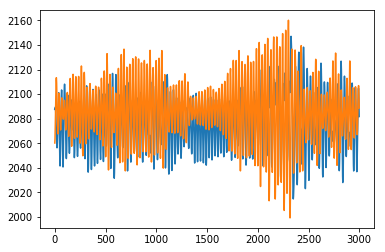

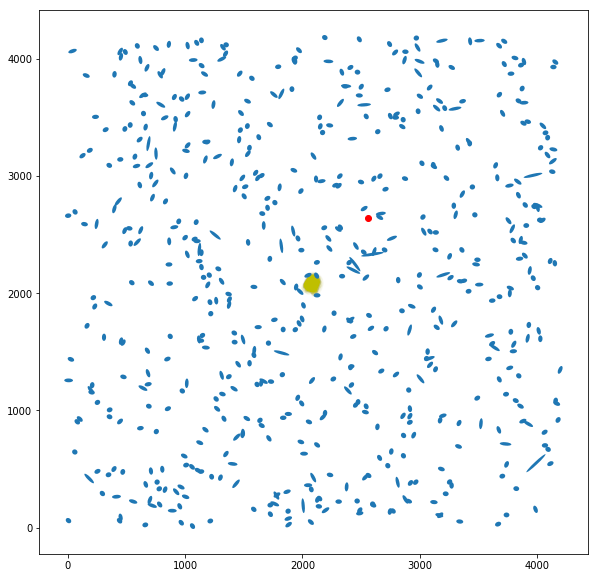

In [262]:
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x,y = _g[0], _g[1]
        d = np.sqrt( _g[2]**2 + _g[3]**2 )
        a = 1.0/ ( 1 - d )
        b = 1.0/( 1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch( Ellipse(xy=(x, y), width=size_multiplier*a, height=size_multiplier*b, angle=theta) )
    ax.autoscale_view(tight=True)
    
    return fig

mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
print(sess.run(qm))
print(mean, stddev)
samples = sess.run(qXh.params)
#plt.hist(samples, bins='auto')
#plt.show()

# Trace plot.
plt.plot(samples)
plt.show()
plt.clf()
fig = draw_sky(all_sky_star[sky][:,1:])
plt.scatter(samples[:,0], samples[:,1], alpha = 0.015, c = "y")
plt.scatter(halo[sky,2],halo[sky,3], c = "r")
plt.show()

# Criticism 2

In [ ]:
plt.clf()
fig = draw_sky(all_sky_star[sky][:,1:])
for i in np.arange(400,4001,1000):
    for j in np.arange(400,4001,1000):
        def constraints_normal(T):
            return tf.minimum(tf.maximum(tf.Variable(tf.random_normal([T, 2], mean=[i, j],stddev=1.)), 0), 4200)

        T = 10000
        qXh = Empirical(params=constraints_normal(T))
        #qsig = Empirical(params=tf.Variable(tf.zeros(10000)))
        inference = ed.SGHMC({Xh: qXh}, data={X: pos_xy, e1:X_e1, e2:X_e2})
        inference.run(step_size=5.)

        mean, stddev = sess.run([qXh.mean(), qXh.stddev()])
        print(mean, stddev)
        samples = sess.run(qXh.params)
        #plt.hist(samples, bins='auto')
        #plt.show()

        # Trace plot.
        # plt.plot(samples)
        # plt.show()


        plt.scatter(samples[200:,0], samples[200:,1], alpha = 0.015, c = "y")
        plt.scatter(halo[sky,2],halo[sky,3], c = "r")
plt.show()

# NN

In [227]:
import edward as ed
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.contrib.distributions as ds

from edward.models import Normal, Uniform, InverseGamma, Empirical

def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)

# print(pos_all_xy.shape)
# print(pos_all_halo.shape)
# print(pos_all_e1_e2.shape)
N = pos_all_xy.shape[0]

# Model

X = tf.placeholder(tf.float32, [N, 2])
X_e1 = pos_all_e1_e2[:,:1].reshape(N).tolist()
X_e2 = pos_all_e1_e2[:,1:].reshape(N).tolist()

# Xh = Uniform(low=[0.,0.],high=[4200., 4200.])
Xh = tf.placeholder(tf.float32, [N, 2])
# Xh = [2315.61, 1082.86]
#m = Uniform(low=10.,high=1000.)
m= 100

l2diff = tf.sqrt(tf.reduce_sum(tf.square(X - Xh), reduction_indices=1))/4200.

sess = ed.get_session()

w0 = Normal(loc=tf.zero(1), scale=tf.ones(1))
b0 = Normal(loc=tf.zero(1), scale=tf.ones(1))
w1 = Normal(loc=tf.zero(1), scale=tf.ones(1))
b1 = Normal(loc=tf.zero(1), scale=tf.ones(1))
w2 = Normal(loc=tf.zero(1), scale=tf.ones(1))
b2 = Normal(loc=tf.zero(1), scale=tf.ones(1))
b3 = Normal(loc=tf.zero(1), scale=tf.ones(1))
y = Normal(loc=(l2diff**(-1)+b0)*w0 +(l2diff**(1)+b1)*w1 + (l2diff**(2)+b2)*w2 + b3, scale=tf.ones(N))
mu = m / y

e1_var = tf.multiply(tangential(X, Xh, 0),mu)
e2_var = tf.multiply(tangential(X, Xh, 1),mu)
sess2 =tf.Session()


In [228]:
qw0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb0 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb1 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qw2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb2 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
qb3 = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))
             
inference = ed.KLqp({w0: qw0, b0: qb0, w1: qw1, b1: qb1, w2: qw2, b2: qb2, b3: qb3}, data={X: pos_all_xy.tolist(), e1_var:X_e1, e2_var:X_e2, Xh : pos_all_halo.tolist()})
inference.run(n_samples=5, n_iter=100)

100/100 [100%] ██████████████████████████████ Elapsed: 11s | Loss: 0.000


In [ ]:
def visualise(X_data, y_data, w, b, n_samples=10):
    w_samples = w.sample(n_samples)[:, 0].eval()
    b_samples = b.sample(n_samples).eval()
    plt.scatter(X_data[:, 0], y_data)
    inputs = np.linspace(-8, 8, num=400)
    for ns in range(n_samples):
        output = inputs * w_samples[ns] + b_samples[ns]
        plt.plot(inputs, output)
    plt.show()
visualise(e1_e2[:,:1], e1_e2[:,1:], qw0, qb0)

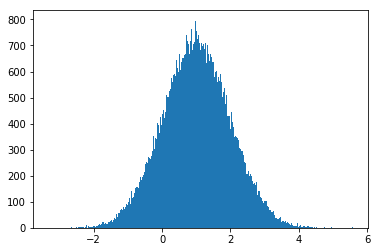

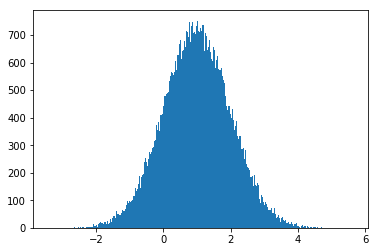

Tensor("Mul_19:0", shape=(50845,), dtype=float32)


In [230]:
w_samples = qw2.sample(100000)[:, 0].eval()
plt.hist(w_samples,500)
plt.show()
w_samples = w1.sample(100000)[:, 0].eval()
plt.hist(w_samples,500)
plt.show()
print(e1_var)


In [267]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * tf.atan2(delta[:,1], delta[:,0])
    return -tf.cos(t) if axis == 0 else -tf.sin(t)
def draw_sky(galaxies):
    """adapted from Vishal Goklani"""
    size_multiplier = 45
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, aspect='equal')
    n = galaxies.shape[0]
    for i in range(n):
        _g = galaxies[i,:]
        x,y = _g[0], _g[1]
        d = np.sqrt( _g[2]**2 + _g[3]**2 )
        a = 1.0/ ( 1 - d )
        b = 1.0/( 1 + d)
        theta = np.degrees( np.arctan2( _g[3], _g[2])*0.5 )
        
        ax.add_patch( Ellipse(xy=(x, y), width=size_multiplier*a, height=size_multiplier*b, angle=theta) )
    ax.autoscale_view(tight=True)
    
    return fig

samples = sess.run(qXh.params)
#plt.hist(samples, bins='auto')
#plt.show()
halo_test = [2100,2100]
glxy_test = np.zeros((4200,4200,2))
for i in range(4200):
    for j in range(4200):
        glxy_test[i][j] = [i,j]

# Trace plot.
# plt.clf()
# fig = draw_sky(all_sky_star[sky][:,1:])
# plt.scatter(halo[sky,2],halo[sky,3], c = "r")
# plt.show()

IndexError: too many indices for array

In [280]:
def tangential(glxy_position, halo_position, axis):
    delta = glxy_position - halo_position
    t = 2 * np.arctan(delta[:,1], delta[:,0])
    return -np.cos(t) if axis == 0 else -np.sin(t)
print(tangential(glxy_test[0], halo_test, axis=1))


[ 0.00095238  0.00095283  0.00095329 ..., -0.00095374 -0.00095329
 -0.00095283]
